In [3]:
import numpy as np
import sys
from scipy import special
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime

ME=9.10938356E-31                       # electron mass, in kilogram
MI=1.6726219E-27                 # ion mass, in kilogram
QE=1.60217662E-19                # elementary charge, in coulomb
EPSILON0=8.8541878128E-12

LOGLAMBDA = 19

In [16]:
class Coulomb():
   
    def __init__(self, qa, qb, ma, mb, temp_b, n, slow = True, para = True, perp = True):
        '''
        qa, ma: charge and mass of test particle [kg, Coulomb]
        qb, mb: charge and mass of background particle [kg, Coulomb]
        temp_b: temperature of background species [eV]
        n:      density of background species [m^-3]
        '''
        self.qa = qa
        self.qb = qb
        self.ma = ma
        self.mb = mb
        self.temp_b = temp_b
        self.temp_j = temp_b * QE # background temperature in Joules
        self.n = n
        
        self.slow = slow
        self.para = para
        self.perp = perp
        
        self.dWt = None
        self.wiener = None
        return
    
    def erf(self, x): 
        '''Error function erf(x)'''
        return special.erf(x)
    
    def nu_ab(self):
        return self.n * (self.qa**2) * (self.qb**2) * LOGLAMBDA / (4*np.pi * (EPSILON0**2) * (self.ma**2))
    
    def ratio_x(self, v):
        vt = np.sqrt(2*self.temp_j / self.mb);
        return v/vt
    
    def G(self, x):
        '''The Chanderaskar G function'''
        gauss = ((2 * x) / np.sqrt(np.pi)) * np.exp(-1 * x**2);
        return (self.erf(x) - gauss)/(2 * x**2)
    
    def nu_s(self, v):
        '''Slowing down frequency'''
        speed = np.linalg.norm(v, axis = -1)
        xb = self.ratio_x(speed);
        return (1/(speed * self.temp_j)) * self.G(xb)* (self.ma + self.mb) * self.nu_ab()
    
    def nu_par(self, v):
        speed = np.linalg.norm(v, axis = -1)
        xb = self.ratio_x(speed)
        return 2 * self.nu_ab() * self.G(xb) / (speed ** 3)
    
    def nu_perp(self, v):
        speed = np.linalg.norm(v, axis = -1)
        xb = self.ratio_x(speed)
        return self.nu_ab() * (self.erf(xb) - self.G(xb))/ (speed ** 3)
    
    def dv_slow(self, dt, v):
        '''
        returns the slowing down dv vector
        '''
        if self.slow:
            bs = v.shape[0]
            nus = self.nu_s(v).reshape(bs, 1)
            return -1 * dt * nus * v # forward Euler for deterministic slowing down
        else:
            return np.zeros(v.shape)
        
    
    def dv_strat(self, dt, v):
        '''
        returns the stratanovich correction to the SDE; to be used in EM method.
        '''
        nuperp = self.nu_perp(v)
        speed = np.linalg.norm(v, axis = -1)
        Dperp = speed**2 * (0.5 * nuperp)
#         multiplier = Dperp / speed**2
        mult = 0.5 * nuperp * dt
        return mult[:, None] * v
    
    def dv_diff_EM(self, dt, v, dW):
        '''
        returns the diffusion dv vector from Euler-Maruyama
        '''
        
        bs = v.shape[0] #batch size of velocities

        nupara = self.nu_par(v)
        nuperp = self.nu_perp(v)
        speed = np.linalg.norm(v, axis = -1)
        Dpara_sqrt  = speed * np.sqrt(0.5 * nupara) * self.para
        Dperp_sqrt = speed * np.sqrt(0.5 * nuperp) * self.perp
#         Dperp_sqrt = Dperp_sqrt / Dperp_sqrt # setting diffusion coef to 1
        
        diag = np.identity(3)
        identities = np.tile(diag, (bs, 1)).reshape(bs, 3, 3)
        vvs = v[:, :, None] * v[:, None, :] / (speed**2)[:, None, None]
        D_mat = vvs * Dpara_sqrt[:, None, None] + (identities - vvs) * Dperp_sqrt[:, None, None]
        
        wiener = np.expand_dims(dW, axis = -1)

        return np.squeeze(np.matmul(D_mat, wiener), -1)
    
    def hatMap(self, vector):
        '''
        converts a given vector to it's corresponding anti-symmetric permutation matrix
        Note: for use with np.apply_along_axis as a functor
        '''
        v1 = vector[0]
        v2 = vector[1]
        v3 = vector[2]
        return np.array([[0, -1*v3, v2], [v3, 0, -1 * v1], [-1*v2, v1, 0]])
    
    def dv_diff_MEM(self, dt, v, dW):
        '''
        returns the updated velocity from combined diffusive processes
        '''
        bs = v.shape[0]
        
        nupara = self.nu_par(v)
        nuperp = self.nu_perp(v)
        
        speed = np.linalg.norm(v, axis = -1)
        Dpara_sqrt  = speed * np.sqrt(0.5 * nupara) * self.para
        Dperp_sqrt = speed * np.sqrt(0.5 * nuperp) * self.perp
        
        diag = np.identity(3)
        identities = np.tile(diag, (bs, 1)).reshape(bs, 3, 3)
        
        omega = np.cross(v, dW)
        omega_hat = np.apply_along_axis(self.hatMap, 1, omega)
        
        T_const = 0.5 * (Dpara_sqrt - Dperp_sqrt)* (speed**-2)

        T_n = T_const[:, None, None] * omega_hat
        A = np.linalg.inv(identities - T_n)
        B = Dpara_sqrt[:, None] * dW
        C = np.squeeze(np.matmul((identities + T_n), np.expand_dims(v, axis = -1)))
        RHS = np.expand_dims(B + C, axis = -1)
        result = np.squeeze(np.matmul(A, RHS))
        return result
    
    def fixedWiener(self, nparts, tTot):
        '''
        Generate a fixed fine-grain Wiener process, pass to class members
        Note: This gauranteed that for each class instantiation, the 'fixed' underlying
                Wiener process is defined only one time.
        '''
#         np.random.seed(0)
        if self.dWt == None:
            self.dWt = tTot * 1E-5
            length = int(tTot/self.dWt) *2
            mean = [0, 0, 0]
            var = np.eye(3) * self.dWt
            self.wiener = np.random.multivariate_normal(mean, var, (length,nparts))
#             print(self.wiener.shape)
        return
        
    
    def wienerProcess(self, dt, bs, fixedWiener = False, tNow = None):
        '''
        returns a wiener process dW, same shape as the currently v inputs
        dt: time step of the simulation
        bs: batch size of the input
        [dWt, wiener]: the dWt that the fixed Wiener process with generated with, and the series itself
        tNow: Current time in simulation
        '''
        if not fixedWiener:
            #print('not fixed')
            mean = [0, 0, 0]
            var = np.eye(3) * dt #[[dt, 0, 0], [0, dt, 0], [0, 0, dt]]
            wiener = np.random.multivariate_normal(mean, var, bs)
            return wiener
        else:
            #print('fixed')
            tNext = tNow + dt
            iNow  = int(tNow / self.dWt)
            iNext = int(tNext/ self.dWt)
                
            try:
                delta_W = self.wiener[iNext, :,:] - self.wiener[iNow, :,:] # (nparts x 3)
#                 return np.tile(delta_W, (bs, 1)) # return the same wiener process for each sample path
                return delta_W
            
            except IndexError:
                print("Error: Trying to reach beyond prepared underlying Wiener process. Adjust Ttot.")
                sys.exit(1)
                

            
    
    def beam_EM(self,E, nparts, dt, tTot, snaps, fixedWiener = False):
        '''
        E:      energy of beam particles [eV]
        nparts: number of particles [#]
        tTot:   total time of simulation [s]
        snaps:  number of snapshots to output; set to '1' for only the initial and final states
        fixedWiener: whether to use a fixed underlying Wiener process
        return: [tHist, vHist] History of velocities (timesteps * nparts * 3) and the corresponding times
        '''
        if fixedWiener:
            self.fixedWiener(nparts, tTot)
            
        v_beam = np.sqrt(2*E*QE/self.ma)
        v = np.tile(np.array([v_beam, 0, 0]), (nparts, 1)) # initialize nparts particles with same velocity
        tnow = 0
        
        # Some preparations so that we can modify vHist by index
        stepsTotal = int(tTot/dt)
        if stepsTotal < snaps:
            print("Total steps: ", stepsTotal, " snaps: ", snaps)
            print("Requested # of snaps is less than total steps; outputting full Hist")
            snaps = stepsTotal
        try:
            dStep = int(stepsTotal / snaps)
        except ZeroDivisionError:
            print("snaps = ", snaps)
            print("beam_EM: snaps can't be 0, setting to 1 for outputting the final state")
            snaps = 1
            dStep = int(stepsTotal)
            
        vHist = np.zeros((int(snaps+1), nparts, 3))
        tHist = np.zeros((int(snaps+1),))
        
        for step in range(stepsTotal):
            dW = self.wienerProcess(dt, nparts, fixedWiener, tnow)
            #print(dW[:3, :])
            dv_s = self.dv_slow(dt, v)
            dv_diff = self.dv_diff_EM(dt, v, dW)
            v = v + dv_s + dv_diff
            if (dStep != 0 and step % dStep == 0):
                index = int(step / dStep)
                vHist[index] = v
                tHist[index] = tnow
            tnow += dt
        #Always keep the final state
        vHist[-1] = v
        tHist[-1] = tnow - dt
        return tHist, vHist
    
    def beam_MEM(self,E, nparts, dt, tTot, snaps, fixedWiener = False):
        '''
        E:      energy of beam particles [eV]
        nparts: number of particles [#]
        tTot:   total time of simulation [s]
        return: History of velocities (timesteps * nparts * 3)
        '''
        if fixedWiener:
            self.fixedWiener(nparts, tTot)
            
        v_beam = np.sqrt(2*E*QE/self.ma)
        v = np.tile(np.array([v_beam, 0, 0]), (nparts, 1)) # initialize nparts particles with same velocity
        tnow = 0
        
        # Some preparations so that we can modify vHist by index
        stepsTotal = int(tTot/dt)
        if stepsTotal < snaps:
            print("Total steps: ", stepsTotal, " snaps: ", snaps)
            print("Requested # of snaps is less than total steps; outputting full Hist")
            snaps = stepsTotal
        try:
            dStep = int(stepsTotal / snaps)
        except ZeroDivisionError:
            print("snaps = ", snaps)
            print("beam_MEM: snaps can't be 0, setting to 1 for outputting the final state")
            snaps = 1
            dStep = int(stepsTotal)
            
        vHist = np.zeros((int(snaps+1), nparts, 3))
        tHist = np.zeros((int(snaps+1),))
        
        for step in range(stepsTotal):
            dW = self.wienerProcess(dt, nparts, fixedWiener, tnow)
            #if fixedWiener: print(dW)
            dv_s = self.dv_slow(dt, v)
            v = self.dv_diff_MEM(dt, v, dW) + dv_s
            if (dStep != 0 and step % dStep == 0):
                index = int(step / dStep)
                vHist[index] = v
                tHist[index] = tnow
            tnow += dt
        #Always keep the final state
        vHist[-1] = v
        tHist[-1] = tnow - dt
        return tHist, vHist
    
    def energyConvergence(self, E, nparts, dt_start, dt_end, t_tot, numTrials, moments = [1, 2],
                          integrator = 'EM', fixedWiener = False, silent = False):
        '''
        nparts:     number of particles per run
        dt_start:   the lowest order of magnitude for dt [log(dt)]
        dt_end:     the highest order of magnitude
        t_tot:      Duration of each simulation
        numTrials:  Number of trials per dt
        moments :   [int] Python list of central moments to calculate
        integrator: Method for integrating diffusion, 'EM' or 'MEM'
        '''
        numT = int((dt_end - dt_start) / 0.2) # number of points in dt
                
        dtList = np.linspace(dt_end, dt_start, numT)
        momList = np.zeros((numT, numTrials, len(moments), 1))
        
        for i in range(numT):
            dt = 10**dtList[i]
            if not silent: print(dt)
            trialList = np.zeros((numTrials, len(moments), 1))
            for j in range(numTrials):
                if fixedWiener:
                    self.dWt = None # flag a reset of the underlying Wiener
                    np.random.seed(i) # use the same states of random numbers for each dt
                    
                if integrator == 'EM':
                    tHist, vHist = self.beam_EM(E, nparts, dt, t_tot, snaps = 2, fixedWiener = fixedWiener)
                elif integrator == 'MEM':
                    tHist, vHist = self.beam_MEM(E, nparts, dt, t_tot, snaps = 2, fixedWiener = fixedWiener)
                else:
                    print('Integrator option not recognized: ', integrator)
                    return 0, 0, 0, 0
                if not silent: print('done with trial', j)
                    
                speed = np.linalg.norm(vHist[-1], axis = -1)
                momOut = np.zeros((len(moments), 1))
                for orderIndex in range(len(moments)):
                    order = moments[orderIndex]
                    moment = stats.moment(speed, moment = order, axis = -1)
                    momOut[orderIndex] = moment
                trialList[j] = momOut
            
            momList[i] = trialList
            dtList[i] = dt
        return dtList, momList       
        
    
    def pitchConvergence(self, E, nparts, dt_start, dt_end, t_tot, numTrials, moments = [1, 2],
                         integrator = 'EM', fixedWiener = False, silent = False):
        '''
        nparts:     number of particles per run
        dt_start:   the lowest order of magnitude for dt [log(dt)]
        dt_end:     the highest order of magnitude
        t_tot:      Duration of each simulation
        numTrials:  Number of trials per dt
        moments :   [int] Python list of central moments to calculate
        integrator: Method for integrating diffusion, 'EM' or 'MEM'
        '''
        
        numT = int((dt_end - dt_start) / 0.2) # number of points in dt
                
        dtList = np.linspace(dt_end, dt_start, numT)
        momList = np.zeros((numT, numTrials, len(moments), 3))
        
        for i in range(numT):
            dt = 10**dtList[i]
            if not silent: print(dt)
            trialList = np.zeros((numTrials, len(moments), 3))
            for j in range(numTrials):
                if fixedWiener:
                    self.dWt = None # flag a reset of the underlying Wiener
                    np.random.seed(i) # use the same states of random numbers for each dt
                    
                if integrator == 'EM':
                    tHist, vHist = self.beam_EM(E, nparts, dt, t_tot, snaps = 2, fixedWiener = fixedWiener)
                elif integrator == 'MEM':
                    tHist, vHist = self.beam_MEM(E, nparts, dt, t_tot, snaps = 2, fixedWiener = fixedWiener)
                else:
                    print('Integrator option not recognized: ', integrator)
                    return 0, 0, 0, 0
                if not silent: print('done with trial', j)
                    
#                 speed = np.linalg.norm(vHist[-1], axis = -1)
                momOut = np.zeros((len(moments), 3))
                for orderIndex in range(len(moments)):
                    order = moments[orderIndex]
                    moment = stats.moment(vHist[-1], moment = order, axis = 0)
                    momOut[orderIndex] = moment
                trialList[j] = momOut
            
            momList[i] = trialList
            dtList[i] = dt
        return dtList, momList
        
        
    
    def pitchIter(self, E, nparts, dt, i_start, i_end, di, numTrials, moments = [1, 2],
                  integrator = 'EM', fixedWiener = False, silent = False):
        '''
        nparts:     number of particles per run
        dt:         time step [s]
        i_start:    starting number of iterations
        i_end:      end number of iterations
        di:         step size in iterations
        numTrials:  Number of trials per i
        moments :   [int] Python list of central moments to calculate
        integrator: Method for integrating diffusion, 'EM' or 'MEM'
        '''
        numI = int((i_end - i_start)/di)
        iList = np.linspace(i_start, i_end, numI)
        momList = np.zeros((numI, numTrials, len(moments), 3))
        for i in range(numI):
            t_tot = dt * iList[i]
            if not silent: print('Pushing ',iterNow, 'iterations, for ', t_tot, 'seconds...')
                
            trialList = np.zeros((numTrials, len(moments), 3))
            for j in range(numTrials):
                if fixedWiener:
                    self.dWt = None # flag a reset of the underlying Wiener
                    np.random.seed(i) # use the same states of random numbers for each dt
                    
                if integrator == 'EM':
                    tHist, vHist = self.beam_EM(E, nparts, dt, t_tot, snaps = 2, fixedWiener = fixedWiener)
                elif integrator == 'MEM':
                    tHist, vHist = self.beam_MEM(E, nparts, dt, t_tot, snaps = 2, fixedWiener = fixedWiener)
                else:
                    print('Integrator option not recognized: ', integrator)
                    return 0, 0, 0, 0
                if not silent: print('done with trial', j)
                    
                momOut = np.zeros((len(moments), 3))
                for orderIndex in range(len(moments)):
                    order = moments[orderIndex]
                    moment = stats.moment(vHist[-1], moment = order, axis = 0)
                    momOut[orderIndex] = moment
                trialList[j] = momOut
            
            momList[i] = trialList
#             iList[i] = dt
        return iList, momList

In [17]:
test = Coulomb(QE, QE, MI, MI, 200, 1E19, False, False, True)

In [18]:
vtest = np.array([[1, 3, 5], [2, 4, 6]])
test.dv_strat(vtest)

array([[2.49385833e+12, 7.48157498e+12, 1.24692916e+13],
       [3.11732279e+12, 6.23464558e+12, 9.35196836e+12]])

In [35]:
print(test.dWt==None)

True


(200000, 2, 3)
(200000, 2, 3)


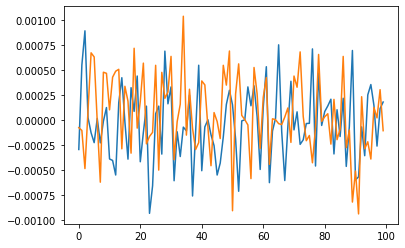

In [32]:
test.fixedWiener(2, 0.01)
print(test.wiener.shape)
plt.plot(test.wiener[:100, :,1])
# print(test.wiener == None)

snaps can't be 0, setting to 1 for outputtting the final state
(2, 5, 3)
(2, 5)


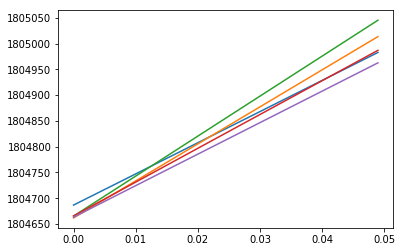

In [70]:
t, vHistBeam4 = test.beam_EM(17000, 5, 1E-3, 0.05, 0, True)
print(vHistBeam4.shape)
speedBeam4 = np.linalg.norm(vHistBeam4, axis = -1)
print(speedBeam4.shape)
# figure = plt.plot(t, vHistBeam4[:, 1, 1])
figure = plt.plot(t, speedBeam4)
# plt.plot(speedBeam4)

(101, 5, 3)
(101, 5)


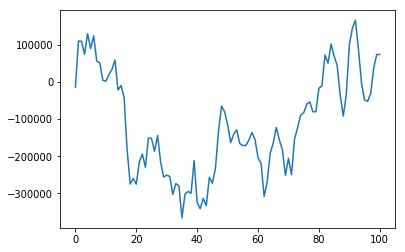

In [83]:
t, vHistMEM4 = test.beam_MEM(17000, 5, 2E-4, 0.02, 1000, False)
print(vHistMEM4.shape)
speedMEM4 = np.linalg.norm(vHistMEM4, axis = -1)
print(speedMEM4.shape)
figure1 = plt.plot(vHistMEM4[:, 1, 1])
# figure2 = plt.plot(speedMEM4)

In [88]:
help(test.energyConvergence)

Help on method energyConvergence in module __main__:

energyConvergence(E, nparts, dt_start, dt_end, t_tot, numTrials, moments=[1, 2], integrator='EM', fixedWiener=False, silent=False) method of __main__.Coulomb instance
    nparts:     number of particles per run
    dt_start:   the lowest order of magnitude for dt [log(dt)]
    dt_end:     the highest order of magnitude
    t_tot:      Duration of each simulation
    numTrials:  Number of trials per dt
    moments :   [int] Python list of central moments to calculate
    integrator: Method for integrating diffusion, 'EM' or 'MEM'



In [192]:
moments = [2, 3, 4]
dtList, momList = test.energyConvergence(17000, 100, -3, -1, 0.2, 5, moments, 'EM', False, True)

(10,) (10, 5, 3, 1)


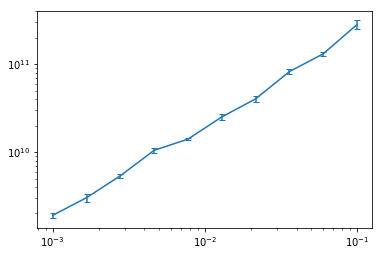

In [195]:
print(dtList.shape, momList.shape)
aveMom = np.mean(momList, axis = 1)
steMom = stats.sem(momList, axis = 1)
# print(aveMom.shape)
# print(dtList, aveMom)
# plt.plot(dtList, aveMom[:, 2, 0])
plt.errorbar(dtList, aveMom[:, 0,0], steMom[:, 0, 0], capsize = 3)
plt.xscale('log')
plt.yscale('log')

In [226]:
moments = [1, 2, 3, 4]
dtList, momList = test.pitchConvergence(17000, 1000, -4, -1, 0.2, 10, moments, 'MEM', False, True)

(15,) (15, 10, 4, 3)
(15, 4, 3)


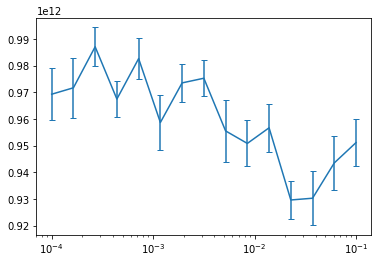

In [235]:
print(dtList.shape, momList.shape)
aveMom = np.mean(momList, axis = 1)
steMom = stats.sem(momList, axis = 1)
print(aveMom.shape)
# print(dtList, aveMom)
# plt.plot(dtList, aveMom[:, 2, 0])
momIndex = 1
plt.errorbar(dtList, aveMom[:, momIndex,1], steMom[:, momIndex, 1], capsize = 3)
plt.xscale('log')
# plt.yscale('log')

In [247]:
moments = [1, 2, 3, 4]
iList, momList = test.pitchIter(17000, 100, 1E-3, 10, 100, 10, 10, moments, 'MEM', False, True)

(9,)
(9, 10, 4, 3)


(9,) (9, 10, 4, 3)
(9, 4, 3)


<ErrorbarContainer object of 3 artists>

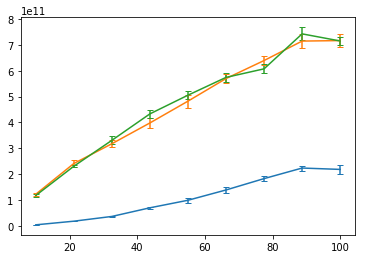

In [253]:
print(iList.shape, momList.shape)
aveMom = np.mean(momList, axis = 1)
steMom = stats.sem(momList, axis = 1)
print(aveMom.shape)
# print(dtList, aveMom)
# plt.plot(iList, aveMom[:, 2, 0])
momIndex = 1
plt.errorbar(iList, aveMom[:, momIndex,0], steMom[:, momIndex, 0], capsize = 3)
plt.errorbar(iList, aveMom[:, momIndex,1], steMom[:, momIndex, 1], capsize = 3)
plt.errorbar(iList, aveMom[:, momIndex,2], steMom[:, momIndex, 2], capsize = 3)

# plt.xscale('log')
# plt.yscale('log')

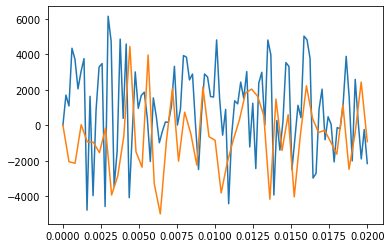

In [50]:
time1 = np.linspace(0, 0.02, vHistBeam4.shape[0])
time2 = np.linspace(0, 0.02, vHistMEM4.shape[0])

figure = plt.plot(time2, vHistMEM4[:, 4, 2])
figure = plt.plot(time1, vHistBeam4[:, 4, 2])


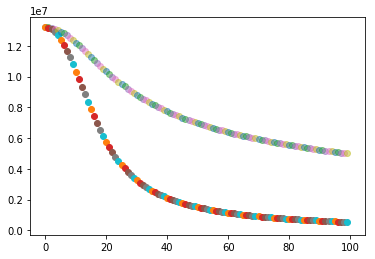

In [5]:
vtest = np.linspace(0.1, 1804661, 100)
for i in range(len(vtest)):
    plt.scatter(i, vtest[i] * np.sqrt(test.nu_perp([vtest[i]])), alpha = 0.5)
    plt.scatter(i, vtest[i] * np.sqrt(test.nu_par([vtest[i]])))    

In [8]:
(vtest[-1] * np.sqrt(test.nu_perp([vtest[-1]])))**2 * 1e-13

2.5022714913819497

In [ ]:
invtest = np.tile(np.eye(3, 3)*2, (3, 1)).reshape(3, 3, 3)
print(invtest)
invout = np.linalg.inv(1-out)
print(invout)

In [266]:
def hatMap(vector):
    v1 = vector[0]
    v2 = vector[1]
    v3 = vector[2]
    return np.array([[0, -v3, v2], [v3, 0, -1 * v1], [-1*v2, v1, 0]])

In [287]:
vtest = np.array([[1, 0, 0], [2, 0, 0], [3, 0, 0]])
fakeWiener = np.array([[0, 10, 20],[0, 10, 20],[0, 10, 20]])
crossed = np.cross(vtest, fakeWiener)
print(crossed)
tensor = np.apply_along_axis(hatMap, 1, crossed)
print(tensor)
print(1+ tensor)
vright = np.squeeze(np.matmul((np.eye(3)+tensor), np.expand_dims(vtest, axis = -1)))
print('right: ', vright)
vfinal = np.squeeze(np.matmul(np.linalg.inv((np.eye(3)- tensor)), np.expand_dims(vright, axis = -1)))
print('final: ', vfinal)

[[  0 -20  10]
 [  0 -40  20]
 [  0 -60  30]]
[[[  0 -10 -20]
  [ 10   0   0]
  [ 20   0   0]]

 [[  0 -20 -40]
  [ 20   0   0]
  [ 40   0   0]]

 [[  0 -30 -60]
  [ 30   0   0]
  [ 60   0   0]]]
[[[  1  -9 -19]
  [ 11   1   1]
  [ 21   1   1]]

 [[  1 -19 -39]
  [ 21   1   1]
  [ 41   1   1]]

 [[  1 -29 -59]
  [ 31   1   1]
  [ 61   1   1]]]
right:  [[  1.  10.  20.]
 [  2.  40.  80.]
 [  3.  90. 180.]]
final:  [[-0.99600798  0.03992016  0.07984032]
 [-1.998001    0.03998001  0.07996002]
 [-2.99866696  0.03999111  0.07998223]]


In [293]:
AinvB = np.matmul(np.linalg.inv((np.eye(3)- tensor)), (np.eye(3)+tensor))
BAinv = np.matmul((np.eye(3)+tensor), np.linalg.inv((np.eye(3)- tensor)))
AinvB - BAinv

array([[[ 0.00000000e+00, -9.43689571e-16,  2.22044605e-16],
        [-9.43689571e-16,  0.00000000e+00,  1.11022302e-16],
        [ 2.22044605e-16, -1.11022302e-16,  0.00000000e+00]],

       [[ 1.11022302e-16, -1.10328413e-15, -8.74300632e-16],
        [-1.10328413e-15,  0.00000000e+00,  0.00000000e+00],
        [-8.74300632e-16,  0.00000000e+00, -2.22044605e-16]],

       [[ 0.00000000e+00, -1.10328413e-15, -9.71445147e-17],
        [-1.10675358e-15, -1.11022302e-16, -2.22044605e-16],
        [-9.71445147e-17,  0.00000000e+00,  1.11022302e-16]]])

In [258]:
vv = np.array([[1, 2, 3], [2, 3, 4], [3, 4, 5]])
out = np.apply_along_axis(hatMap, 1, vv)
print(out)
vtest = np.array([[1, 0, 0], [2, 0, 0], [3, 0, 0]])
vright = np.squeeze(np.matmul((1+ out), np.expand_dims(vtest, axis = -1)))
print('right: ', vright)
vfinal = np.squeeze(np.matmul(np.linalg.inv((1- out)), np.expand_dims(vright, axis = -1)))
print('final: ', vfinal)

[[[ 0  3 -2]
  [ 3  0 -1]
  [-2  1  0]]

 [[ 0  4 -3]
  [ 4  0 -2]
  [-3  2  0]]

 [[ 0  5 -4]
  [ 5  0 -3]
  [-4  3  0]]]
right:  [[ 1  4 -1]
 [ 2 10 -4]
 [ 3 18 -9]]
final:  [[-0.66666667  0.66666667  1.        ]
 [-1.11111111  1.33333333  1.77777778]
 [-1.5         2.          2.5       ]]


In [547]:
j = np.mean(vHistBeam4[-1, :, :], axis = 0)
print(j)

j = np.vstack((j, j))
print(j)
j = np.vstack((j , j))
print(j)

[1832712.49371735  -64905.72156145   50572.62682703]
[[1832712.49371735  -64905.72156145   50572.62682703]
 [1832712.49371735  -64905.72156145   50572.62682703]]
[[1832712.49371735  -64905.72156145   50572.62682703]
 [1832712.49371735  -64905.72156145   50572.62682703]
 [1832712.49371735  -64905.72156145   50572.62682703]
 [1832712.49371735  -64905.72156145   50572.62682703]]


In [623]:
vHist2 = test.beam_MEM(17000, 100, 1E-2, 0.2)
speed2 = np.linalg.norm(vHist2, axis = -1)
vHist4 = test.beam_MEM(17000, 100, 1E-4, 0.2)
speed4 = np.linalg.norm(vHist4, axis = -1)

In [203]:
print(vHist4.shape)

(2002, 100, 3)


In [624]:
vHist2_EM = test.beam_EM(17000, 100, 1E-2, 0.2)
speed2_EM = np.linalg.norm(vHist2_EM, axis = -1)
vHist4_EM = test.beam_EM(17000, 100, 1E-4, 0.2)
speed4_EM = np.linalg.norm(vHist4_EM, axis = -1)

(21, 100, 3)
(21, 100)


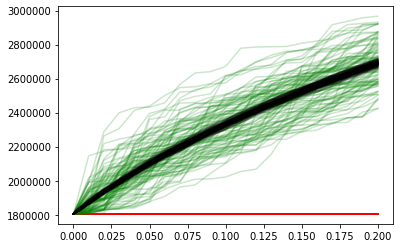

In [625]:
print(vHist2.shape)
print(speed2.shape)
time2 = np.linspace(0, 0.2, vHist2.shape[0])
time4 = np.linspace(0, 0.2, vHist4.shape[0])

# plt.plot(time4, (speed4 - speed4[0]), 'b', alpha = 0.2, label = '1E-2')
# plt.plot(time2, (speed2 - speed2[0]), 'r', alpha = 0.2, label = '1E-4')
fig = plt.plot(time4, speed4, 'b', alpha = 0.2, label = '1E-4')
fig = plt.plot(time2, speed2, 'r', alpha = 0.2, label = '1E-2')
fig = plt.plot(time2, speed2_EM, 'g', alpha = 0.2, label = '1E-2')
fig = plt.plot(time4, speed4_EM, 'k', alpha = 0.2, label = '1E-2')
# plt.legend()

(21, 100, 3)
(21, 100)


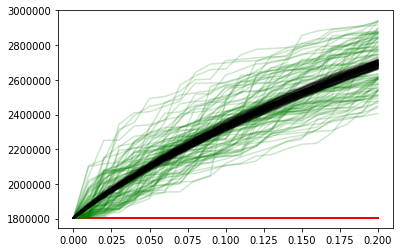

In [451]:
print(vHist2.shape)
print(speed2.shape)
time2 = np.linspace(0, 0.2, vHist2.shape[0])
time4 = np.linspace(0, 0.2, vHist4.shape[0])

# plt.plot(time4, (speed4 - speed4[0]), 'b', alpha = 0.2, label = '1E-2')
# plt.plot(time2, (speed2 - speed2[0]), 'r', alpha = 0.2, label = '1E-4')
fig = plt.plot(time4, speed4, 'b', alpha = 0.2, label = '1E-4')
fig = plt.plot(time2, speed2, 'r', alpha = 0.2, label = '1E-2')
fig = plt.plot(time2, speed2_EM, 'g', alpha = 0.2, label = '1E-2')
fig = plt.plot(time4, speed4_EM, 'k', alpha = 0.2, label = '1E-2')
# plt.legend()

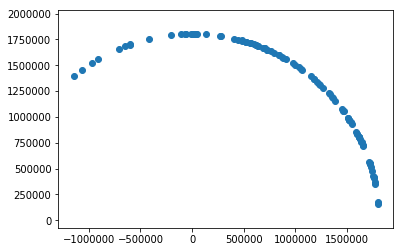

In [204]:
tslice = 2001
vx4 = vHist4[tslice, :, 0];
vy4 = vHist4[tslice, :, 1];
vz4 = vHist4[tslice, :, 2];
vperp4 = np.sqrt(vy4**2 + vz4**2);
# vexp4 = np.sqrt(vHist4[0, :, 0]**2 - vx4**2)
plt.scatter(vx4, vperp4);
# plt.scatter(vx4, vexp4)
plt.axis('equal');

(array([ 2.,  6., 89.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-58.79004392, -32.4275789 ,  -6.06511388,  20.29735114,
         46.65981616,  73.02228118,  99.3847462 , 125.74721121,
        152.10967623, 178.47214125, 204.83460627, 231.19707129,
        257.55953631, 283.92200133, 310.28446635, 336.64693137,
        363.00939639, 389.37186141, 415.73432643, 442.09679145,
        468.45925647]),
 <a list of 20 Patch objects>)

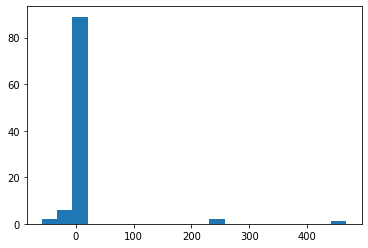

In [615]:
plt.hist(vperp4 / vx4, 20)

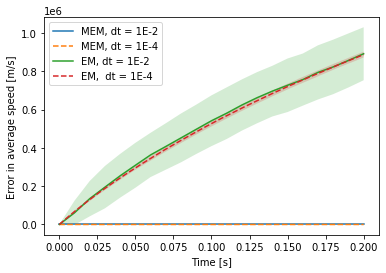

In [467]:
ave4 = np.mean(speed4, axis = -1)
ave2 = np.mean(speed2, axis = -1)
ave4_EM = np.mean(speed4_EM, axis = -1)
ave2_EM = np.mean(speed2_EM, axis = -1)

std4 = np.std(speed4, axis = -1)
std2 = np.std(speed2, axis = -1)
std4_EM = np.std(speed4_EM, axis = -1)
std2_EM = np.std(speed2_EM, axis = -1)

fig2 = plt.plot(time2, ave2 - ave2[0])
fig2 = plt.plot(time4, ave4 - ave4[0], '--')
fig2 = plt.plot(time2, ave2_EM - ave2_EM[0])
fig2 = plt.plot(time4, ave4_EM - ave4_EM[0],'--')

fig2 = plt.fill_between(time2, ave2 - ave2[0] - std2, ave2 - ave2[0] + std2, alpha = 0.2)
fig2 = plt.fill_between(time4, ave4 - ave4[0] - std4, ave4 - ave4[0] + std4, alpha = 0.2)
fig2 = plt.fill_between(time2, ave2_EM - ave2_EM[0] - std2_EM, ave2_EM - ave2_EM[0] + std2_EM, alpha = 0.2)
fig2 = plt.fill_between(time4, ave4_EM - ave4_EM[0] - std4_EM, ave4_EM - ave4_EM[0] + std4_EM, alpha = 0.2)
# plt.label(['MEM, dt = 1E-2', 'MEM, dt = 1E-4', 'EM, dt = 1E-2', 'EM,  dt = 1E-4'])
fig2 = plt.legend(['MEM, dt = 1E-2', 'MEM, dt = 1E-4', 'EM, dt = 1E-2', 'EM,  dt = 1E-4'])
fig2 = plt.xlabel('Time [s]')
fig2 = plt.ylabel('Error in average speed [m/s]')
fig2 = plt.ticklabel_format(axis = 'y', style = 'sci', scilimits=(0, 0))
plt.savefig('Comparison.pdf')
# plt.yscale('log')

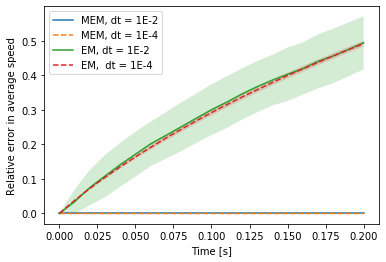

In [480]:
ave4 = np.mean(speed4, axis = -1)
ave2 = np.mean(speed2, axis = -1)
ave4_EM = np.mean(speed4_EM, axis = -1)
ave2_EM = np.mean(speed2_EM, axis = -1)

std4 = np.std(speed4, axis = -1)
std2 = np.std(speed2, axis = -1)
std4_EM = np.std(speed4_EM, axis = -1)
std2_EM = np.std(speed2_EM, axis = -1)

fig2 = plt.plot(time2, (ave2 - ave2[0])/ave2[0])
fig2 = plt.plot(time4, (ave4 - ave4[0])/ave4[0], '--')
fig2 = plt.plot(time2, (ave2_EM - ave2_EM[0])/ave2_EM[0])
fig2 = plt.plot(time4, (ave4_EM - ave4_EM[0])/ave4_EM[0],'--')

fig2 = plt.fill_between(time2, (ave2 - ave2[0] - std2)/ave2[0], (ave2 - ave2[0] + std2)/ave2[0], alpha = 0.2)
fig2 = plt.fill_between(time4, (ave4 - ave4[0] - std4)/ave4[0], (ave4 - ave4[0] + std4)/ave4[0], alpha = 0.2)
fig2 = plt.fill_between(time2, (ave2_EM - ave2_EM[0] - std2_EM)/ave2_EM[0], (ave2_EM - ave2_EM[0] + std2_EM)/ave2_EM[0], alpha = 0.2)
fig2 = plt.fill_between(time4, (ave4_EM - ave4_EM[0] - std4_EM)/ave4_EM[0], (ave4_EM - ave4_EM[0] + std4_EM)/ave4_EM[0], alpha = 0.2)
# plt.label(['MEM, dt = 1E-2', 'MEM, dt = 1E-4', 'EM, dt = 1E-2', 'EM,  dt = 1E-4'])
fig2 = plt.legend(['MEM, dt = 1E-2', 'MEM, dt = 1E-4', 'EM, dt = 1E-2', 'EM,  dt = 1E-4'])
fig2 = plt.xlabel('Time [s]')
fig2 = plt.ylabel('Relative error in average speed')
# fig2 = plt.ticklabel_format(axis = 'y', style = 'sci', scilimits=(0, 0))
plt.savefig('ComparisonPercent.pdf')
# plt.yscale('log')

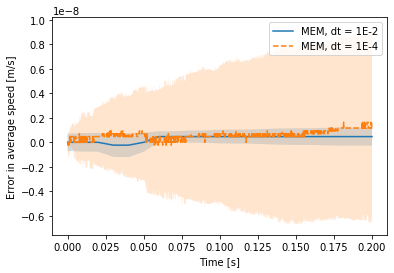

In [483]:
fig3 = plt.plot(time2, ave2 - ave2[0])
fig3 = plt.plot(time4, ave4 - ave4[0], '--')

fig3 = plt.fill_between(time2, ave2 - ave2[0] - std2, ave2 - ave2[0] + std2, alpha = 0.2)
fig3 = plt.fill_between(time4, ave4 - ave4[0] - std4, ave4 - ave4[0] + std4, alpha = 0.2)
fig3 = plt.legend(['MEM, dt = 1E-2', 'MEM, dt = 1E-4'])
fig3 = plt.xlabel('Time [s]')
fig3 = plt.ylabel('Error in average speed [m/s]')
fig3 = plt.ticklabel_format(axis = 'y', style = 'sci', scilimits=(0, 0))
plt.savefig('MEM.pdf')

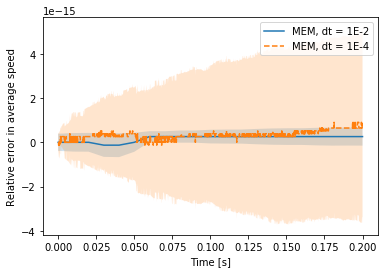

In [485]:
fig2 = plt.plot(time2, (ave2 - ave2[0])/ave2[0])
fig2 = plt.plot(time4, (ave4 - ave4[0])/ave4[0], '--')

fig2 = plt.fill_between(time2, (ave2 - ave2[0] - std2)/ave2[0], (ave2 - ave2[0] + std2)/ave2[0], alpha = 0.2)
fig2 = plt.fill_between(time4, (ave4 - ave4[0] - std4)/ave4[0], (ave4 - ave4[0] + std4)/ave4[0], alpha = 0.2)
fig2 = plt.legend(['MEM, dt = 1E-2', 'MEM, dt = 1E-4'])
fig2 = plt.xlabel('Time [s]')
fig2 = plt.ylabel('Relative error in average speed')
# fig2 = plt.ticklabel_format(axis = 'y', style = 'sci', scilimits=(0, 0))
plt.savefig('MEM_relative.pdf')

(21, 100, 3)
(21, 100)


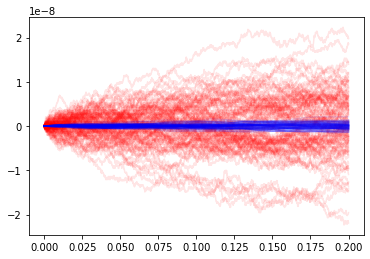

In [472]:
print(vHist2.shape)
print(speed2.shape)
time2 = np.linspace(0, 0.2, vHist2.shape[0])
time4 = np.linspace(0, 0.2, vHist4.shape[0])

# plt.plot(time4, (speed4 - speed4[0]), 'b', alpha = 0.2, label = '1E-2')
# plt.plot(time2, (speed2 - speed2[0]), 'r', alpha = 0.2, label = '1E-4')
fig = plt.plot(time4, (speed4 - speed4[0, :]),'r', alpha = 0.1, label = '1E-4')
fig = plt.plot(time2, (speed2 - speed2[0,:]),'b', alpha = 0.1, label = '1E-2')
# plt.legend()
# plt.yscale('log')

(21, 100, 3)
(21, 100)


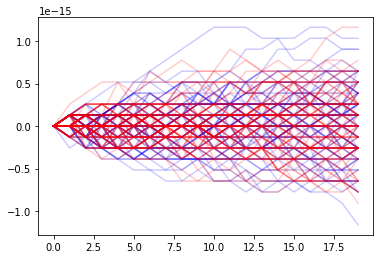

In [469]:
print(vHist2.shape)
print(speed2.shape)
time2 = np.linspace(0, 0.2, vHist2.shape[0])
time4 = np.linspace(0, 0.2, vHist4.shape[0])
length = np.amin([len(time2), len(time4)])
xaxis = np.arange(length-1)

# plt.plot(time4, (speed4 - speed4[0]), 'b', alpha = 0.2, label = '1E-2')
# plt.plot(time2, (speed2 - speed2[0]), 'r', alpha = 0.2, label = '1E-4')
fig = plt.plot(xaxis, (speed4[0:length-1, :] - speed4[0, :])/speed4[0,:], 'b', alpha = 0.2, label = '1E-4')
fig = plt.plot(xaxis, (speed2[0:length-1, :] - speed2[0,:])/speed2[0,:], 'r', alpha = 0.2, label = '1E-2')
# plt.legend()
# plt.yscale('log')

In [388]:
np.amin([len(time4), len(time2)])

21

In [369]:
a, b, c, init = test.convergenceTest(17000, 100, -4, -1, 0.2, 5, 'MEM')

0.0001
done with trial 0
done with trial 1
done with trial 2
done with trial 3
done with trial 4
0.00015848931924611142
done with trial 0
done with trial 1
done with trial 2
done with trial 3
done with trial 4
0.0002511886431509582
done with trial 0
done with trial 1
done with trial 2
done with trial 3
done with trial 4
0.00039810717055349773
done with trial 0
done with trial 1
done with trial 2
done with trial 3
done with trial 4
0.0006309573444801943
done with trial 0
done with trial 1
done with trial 2
done with trial 3
done with trial 4
0.001000000000000002
done with trial 0
done with trial 1
done with trial 2
done with trial 3
done with trial 4
0.0015848931924611173
done with trial 0
done with trial 1
done with trial 2
done with trial 3
done with trial 4
0.0025118864315095872
done with trial 0
done with trial 1
done with trial 2
done with trial 3
done with trial 4
0.0039810717055349856
done with trial 0
done with trial 1
done with trial 2
done with trial 3
done with trial 4
0.0063

Text(0.5, 1.0, 'Error in Speed')

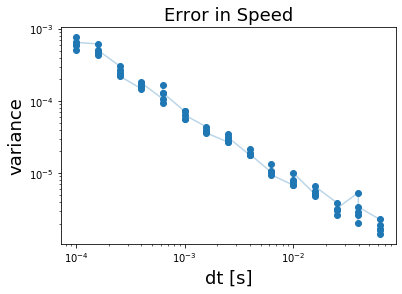

In [370]:
plt.plot(a, c, alpha = 0.3)
plt.scatter(a, c)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('variance', fontsize = 18)
plt.xlabel('dt [s]', fontsize = 18)
plt.title('Error in Speed', fontsize = 18)

Text(0.5, 1.0, 'Error in Speed')

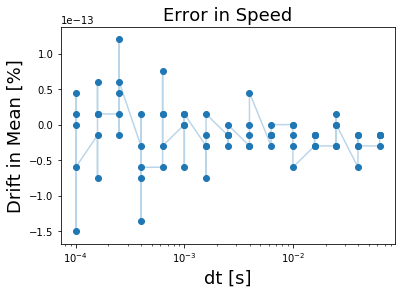

In [371]:
plt.plot(a, (b-init)*100/init, alpha = 0.3)
plt.scatter(a, (b-init)*100/init)
# plt.yscale('log')
plt.xscale('log')
plt.ylabel('Drift in Mean [%]', fontsize = 18)
plt.xlabel('dt [s]', fontsize = 18)
plt.title('Error in Speed', fontsize = 18)

In [48]:
iters, imean, ivar, i_pitch_mean, i_pitch_var, v_init = test.pitchIter(17000, 100, 1E-3, 500, 5000, 100, 5, 'MEM', silent = True)

In [40]:
np.linalg.norm(v_init)

1804661.5446365294

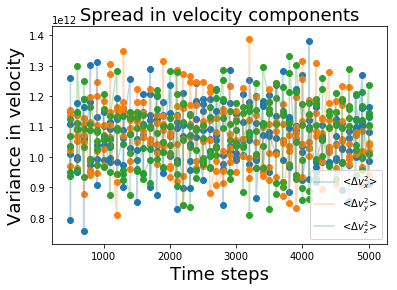

In [49]:
plt.plot(iters, ivar[:, 0], alpha = 0.3)
plt.scatter(iters, ivar[:, 0])
plt.plot(iters, ivar[:, 1], alpha = 0.3)
plt.scatter(iters, ivar[:, 1])
plt.plot(iters, ivar[:, 2], alpha = 0.3)
plt.scatter(iters, ivar[:, 2])
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel('Variance in velocity', fontsize = 18)
plt.xlabel('Time steps', fontsize = 18)
plt.title('Spread in velocity components', fontsize = 18)
plt.legend(['<$\Delta v_x^2$>', '<$\Delta v_y^2$>', '<$\Delta v_z^2$>'])
plt.savefig('velocity_spread_iterations_5000.pdf')

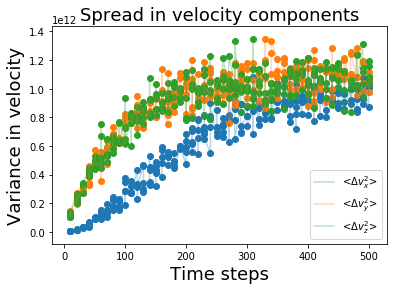

In [37]:
plt.plot(iters, ivar[:, 0], alpha = 0.3)
plt.scatter(iters, ivar[:, 0])
plt.plot(iters, ivar[:, 1], alpha = 0.3)
plt.scatter(iters, ivar[:, 1])
plt.plot(iters, ivar[:, 2], alpha = 0.3)
plt.scatter(iters, ivar[:, 2])
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel('Variance in velocity', fontsize = 18)
plt.xlabel('Time steps', fontsize = 18)
plt.title('Spread in velocity components', fontsize = 18)
plt.legend(['<$\Delta v_x^2$>', '<$\Delta v_y^2$>', '<$\Delta v_z^2$>'])
plt.savefig('velocity_spread_iterations_500.pdf')

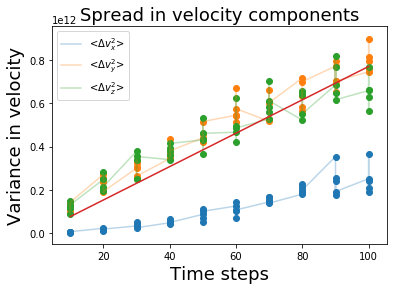

In [47]:
plt.plot(iters, ivar[:, 0], alpha = 0.3)
plt.scatter(iters, ivar[:, 0])
plt.plot(iters, ivar[:, 1], alpha = 0.3)
plt.scatter(iters, ivar[:, 1])
plt.plot(iters, ivar[:, 2], alpha = 0.3)
plt.scatter(iters, ivar[:, 2])
# plt.yscale('log')
# plt.xscale('log')
plt.plot(iters, 7.7*(10**12) * iters * 0.001)
plt.ylabel('Variance in velocity', fontsize = 18)
plt.xlabel('Time steps', fontsize = 18)
plt.title('Spread in velocity components', fontsize = 18)
plt.legend(['<$\Delta v_x^2$>', '<$\Delta v_y^2$>', '<$\Delta v_z^2$>'])
plt.savefig('velocity_spread_iterations_100.pdf')

In [92]:
3.6E13

NameError: name 'iters' is not defined

In [87]:
a0, b0, c0, init0 = test.energyConvergence(17000, 100, -4, -1, 0.2, 5, 'EM', True, True)

0.0001


TypeError: data type not understood

Text(0.5, 1.0, 'Error in Speed')

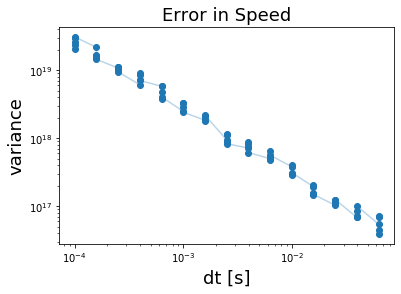

In [82]:
plt.plot(a0, c0, alpha = 0.3)
plt.scatter(a0, c0)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('variance', fontsize = 18)
plt.xlabel('dt [s]', fontsize = 18)
plt.title('Error in Speed', fontsize = 18)

Text(0.5, 1.0, 'Error in Speed')

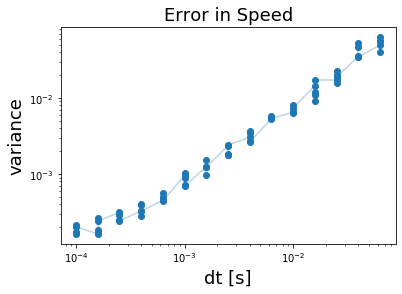

In [373]:
plt.plot(a0, c0, alpha = 0.3)
plt.scatter(a0, c0)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('variance', fontsize = 18)
plt.xlabel('dt [s]', fontsize = 18)
plt.title('Error in Speed', fontsize = 18)

Text(0.5, 1.0, 'Error in Speed')

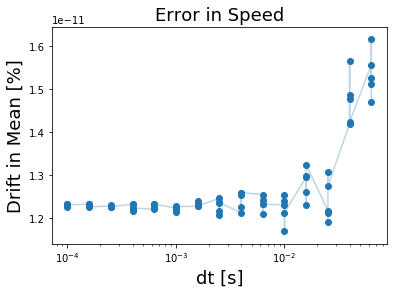

In [374]:
plt.plot(a0, (b0-init0)*100/init0, alpha = 0.3)
plt.scatter(a0, (b0-init0)*100/init0)
# plt.yscale('log')
plt.xscale('log')
plt.ylabel('Drift in Mean [%]', fontsize = 18)
plt.xlabel('dt [s]', fontsize = 18)
plt.title('Error in Speed', fontsize = 18)

In [125]:
time, vMean, vVar, thetaMean, thetaVar, vinit = test.pitchConvergence(17000, 100, -4, -1, 
                                                                           0.2, 1, 'MEM', silent = True)

In [117]:
time5, vMean5, vVar5, thetaMean5, thetaVar5, vinit5 = test.pitchConvergence(17000, 100, -4, -1, 
                                                                           0.2, 5, 'MEM', silent = True)

In [118]:
time10, vMean10, vVar10, thetaMean10, thetaVar10, vinit10 = test.pitchConvergence(17000, 100, -4, -1, 
                                                                                0.2, 10, 'MEM', silent = True)

In [194]:
time10_M, vMean10_M, vVar10_M, thetaMean10_M, thetaVar10_M, vinit10_M = test.pitchConvergence(17000, 500, -4, -1, 
                                                                                0.2, 10, 'MEM', silent = True)

In [195]:
time10_L, vMean10_L, vVar10_L, thetaMean10_L, thetaVar10_L, vinit10_L = test.pitchConvergence(17000, 1000, -4, -1, 
                                                                                0.2, 10, 'MEM', silent = True)

In [119]:
time50, vMean50, vVar50, thetaMean50, thetaVar50, vinit50 = test.pitchConvergence(17000, 100, -4, -1, 
                                                                                0.2, 50, 'MEM', silent = True)

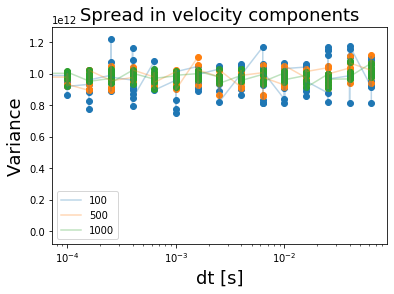

In [201]:
plt.plot(time10, vVar10[:, 1], alpha = 0.3)
plt.scatter(time10, vVar10[:, 1])
plt.plot(time10_M, vVar10_M[:, 1], alpha = 0.3)
plt.scatter(time10_M, vVar10_M[:, 1])
plt.plot(time10_L, vVar10_L[:, 1], alpha = 0.3)
plt.scatter(time10_L, vVar10_L[:, 1])
# plt.yscale('log')
plt.xscale('log')
plt.ylabel('Variance', fontsize = 18)
plt.xlabel('dt [s]', fontsize = 18)
plt.title('Spread in velocity components', fontsize = 18)
plt.legend(['100', '500', '1000'])
plt.savefig('velocity_spread.pdf')

In [83]:
time, vMean, vVar, thetaMean, thetaVar, vinit = test.pitchConvergence(17000, 100, -4, -1, 
                                                                           0.2, 1, 'EM', silent = True)

In [84]:
time5, vMean5, vVar5, thetaMean5, thetaVar5, vinit5 = test.pitchConvergence(17000, 100, -4, -1, 
                                                                           0.2, 5, 'EM', silent = True)

In [85]:
time10, vMean10, vVar10, thetaMean10, thetaVar10, vinit10 = test.pitchConvergence(17000, 100, -4, -1, 
                                                                                0.2, 10, 'EM', silent = True)

In [86]:
time10_M, vMean10_M, vVar10_M, thetaMean10_M, thetaVar10_M, vinit10_M = test.pitchConvergence(17000, 500, -4, -1, 
                                                                                0.2, 10, 'EM', silent = True)

KeyboardInterrupt: 

In [ ]:
time10_L, vMean10_L, vVar10_L, thetaMean10_L, thetaVar10_L, vinit10_L = test.pitchConvergence(17000, 1000, -4, -1, 
                                                                                0.2, 10, 'EM', silent = True)

In [87]:
time50, vMean50, vVar50, thetaMean50, thetaVar50, vinit50 = test.pitchConvergence(17000, 100, -4, -1, 
                                                                                0.2, 50, 'EM', silent = True)

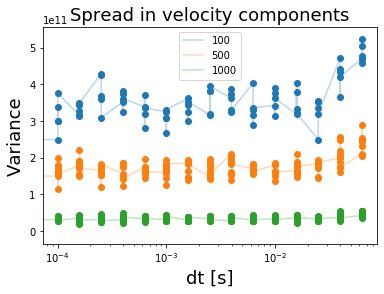

In [91]:
v_axis = 1
plt.plot(time5, vVar5[:, v_axis]/5, alpha = 0.3)
plt.scatter(time5, vVar5[:, v_axis]/5)
plt.plot(time10, vVar10[:, v_axis]/10, alpha = 0.3)
plt.scatter(time10, vVar10[:, v_axis]/10)
plt.plot(time50, vVar50[:, v_axis]/50, alpha = 0.3)
plt.scatter(time50, vVar50[:, v_axis]/50)
# plt.yscale('log')
plt.xscale('log')
plt.ylabel('Variance', fontsize = 18)
plt.xlabel('dt [s]', fontsize = 18)
plt.title('Spread in velocity components', fontsize = 18)
plt.legend(['100', '500', '1000'])
plt.savefig('velocity_spread.pdf')

In [142]:
time5 =np.hstack((0, time5))

In [147]:
time5_single = time5[1:].reshape((15, -1))[:, 0]
time5_single

array([0.0001    , 0.00015849, 0.00025119, 0.00039811, 0.00063096,
       0.001     , 0.00158489, 0.00251189, 0.00398107, 0.00630957,
       0.01      , 0.01584893, 0.02511886, 0.03981072, 0.06309573])

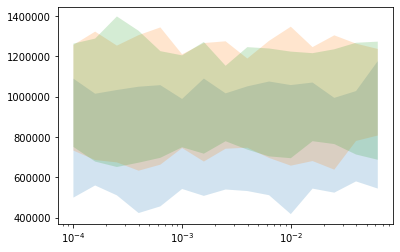

In [191]:
vMean5_shaped = vMean5[1:, :].reshape(15, -1, 3)
vMM5 = np.mean(vMean5_shaped, axis = 1)
vVar5_shaped = vVar5[1:, :].reshape(15, -1, 3)
vRMS5 = np.sqrt(np.mean(vVar5_shaped, axis = 1)) # RMS deviation, observable
vRMS_err5 = np.sqrt(np.sqrt(np.var(vVar5_shaped, axis = 1))) # std of the RMS deviation
# plt.scatter([time5_single,time5_single,time5_single], vRMS5)
vRMS_err5.shape
plt.fill_between(time5_single, vRMS5[:,0] - vRMS_err5[:,0], vRMS5[:,0] + vRMS_err5[:,0], alpha = 0.2)
plt.fill_between(time5_single, vRMS5[:,1] - vRMS_err5[:,1], vRMS5[:,1] + vRMS_err5[:,1], alpha = 0.2)
plt.fill_between(time5_single, vRMS5[:,2] - vRMS_err5[:,2], vRMS5[:,2] + vRMS_err5[:,2], alpha = 0.2)
plt.xscale('log')

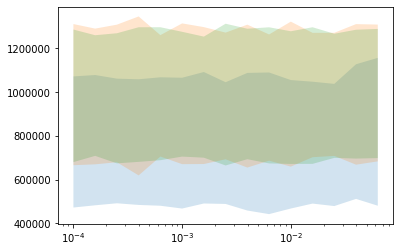

In [193]:
time50_single = time50[1:].reshape((15, -1))[:, 0]
vMean50_shaped = vMean50[1:, :].reshape(15, -1, 3)
vMM50 = np.mean(vMean50_shaped, axis = 1)
vVar50_shaped = vVar50[1:, :].reshape(15, -1, 3)
vRMS50 = np.sqrt(np.mean(vVar50_shaped, axis = 1)) # RMS deviation, observable
vRMS_err50 = np.sqrt(np.sqrt(np.var(vVar50_shaped, axis = 1))) # std of the RMS deviation
# plt.scatter([time5_single,time5_single,time5_single], vRMS5)
vRMS_err50.shape
plt.fill_between(time50_single, vRMS50[:,0] - vRMS_err50[:,0], vRMS50[:,0] + vRMS_err50[:,0], alpha = 0.2)
plt.fill_between(time50_single, vRMS50[:,1] - vRMS_err50[:,1], vRMS50[:,1] + vRMS_err50[:,1], alpha = 0.2)
plt.fill_between(time50_single, vRMS50[:,2] - vRMS_err50[:,2], vRMS50[:,2] + vRMS_err50[:,2], alpha = 0.2)
plt.xscale('log')

In [181]:
print(vRMS5.shape)
np.var(vVar5_shaped, axis = 1)

(15, 3)


array([[7.57256517e+21, 4.70881157e+21, 4.30178878e+21],
       [2.67758742e+21, 1.02962551e+22, 8.65852438e+21],
       [4.65482020e+21, 7.03284839e+21, 1.94276926e+22],
       [9.63634515e+21, 1.27786062e+22, 1.14291769e+22],
       [8.16259345e+21, 1.34192321e+22, 4.88846636e+21],
       [2.48450024e+21, 2.91503390e+21, 2.69425926e+21],
       [7.16542031e+21, 7.45087234e+21, 5.89063441e+21],
       [3.23193169e+21, 5.03779317e+21, 1.22496911e+21],
       [4.53971267e+21, 2.39120390e+21, 4.17154243e+21],
       [6.31765027e+21, 7.11203877e+21, 5.12350547e+21],
       [1.04868531e+22, 1.41079790e+22, 4.87736060e+21],
       [4.78873928e+21, 6.36837942e+21, 2.26784800e+21],
       [3.05226266e+21, 1.23134113e+22, 3.05143433e+21],
       [2.51894739e+21, 3.39478087e+21, 5.89616699e+21],
       [9.98774590e+21, 2.12179446e+21, 7.36689789e+21]])

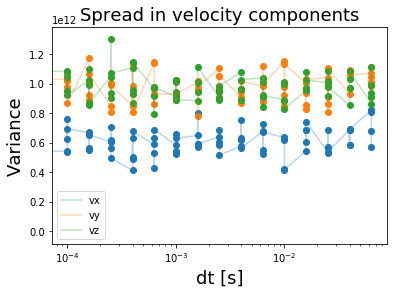

In [196]:
plt.plot(time5, vVar5[:, 0], alpha = 0.3)
plt.scatter(time5, vVar5[:, 0])
plt.plot(time5, vVar5[:, 1], alpha = 0.3)
plt.scatter(time5, vVar5[:, 1])
plt.plot(time5, vVar5[:, 2], alpha = 0.3)
plt.scatter(time5, vVar5[:, 2])
# plt.yscale('log')
plt.xscale('log')
plt.ylabel('Variance', fontsize = 18)
plt.xlabel('dt [s]', fontsize = 18)
plt.title('Spread in velocity components', fontsize = 18)
plt.legend(['vx', 'vy', 'vz'])
plt.savefig('velocity_spread.pdf')

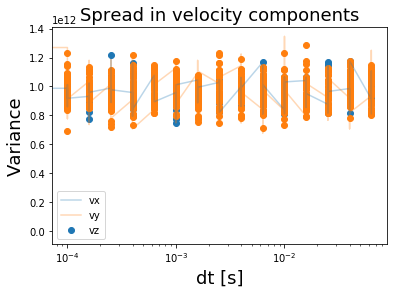

In [124]:
plt.plot(time10, vVar10[:, 1], alpha = 0.3)
plt.scatter(time10, vVar10[:, 1])
plt.plot(time50, vVar50[:, 1], alpha = 0.3)
plt.scatter(time50, vVar50[:, 2])
# plt.yscale('log')
plt.xscale('log')
plt.ylabel('Variance', fontsize = 18)
plt.xlabel('dt [s]', fontsize = 18)
plt.title('Spread in velocity components', fontsize = 18)
plt.legend(['vx', 'vy', 'vz'])
plt.savefig('velocity_spread.pdf')

In [108]:
vVar50.shape

(151, 3)

Text(0.5, 1.0, 'Average Velocity')

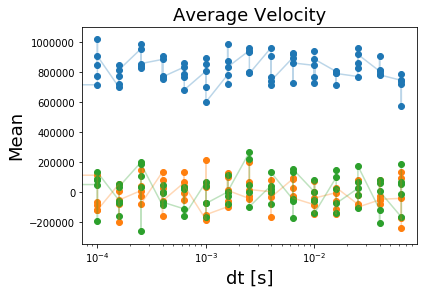

In [599]:
plt.plot(time, vMean[:, 0], alpha = 0.3)
plt.scatter(time, vMean[:, 0])
plt.plot(time, vMean[:, 1], alpha = 0.3)
plt.scatter(time, vMean[:, 1])
plt.plot(time, vMean[:, 2], alpha = 0.3)
plt.scatter(time, vMean[:, 2])
# plt.yscale('log')
plt.xscale('log')
plt.ylabel('Mean', fontsize = 18)
plt.xlabel('dt [s]', fontsize = 18)
plt.title('Average Velocity', fontsize = 18)

In [610]:
thetaMean.shape

(76, 1)

Text(0.5, 1.0, 'Average Velocity')

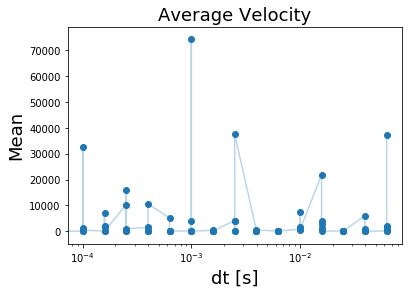

In [612]:
plt.plot(time, thetaVar, alpha = 0.3)
plt.scatter(time, thetaVar)
# plt.yscale('log')
plt.xscale('log')
plt.ylabel('Mean', fontsize = 18)
plt.xlabel('dt [s]', fontsize = 18)
plt.title('Average Velocity', fontsize = 18)

In [72]:
test = Coulomb(QE, QE, MI, MI, 200, 1E19, False, False, True)
time_fix, vMean_fix, vVar_fix, thetaMean_fix, thetaVar_fix, vinit_fix = test.pitchConvergence(17000, 100, -4, -1, 0.2, 5, 'EM', True, True)

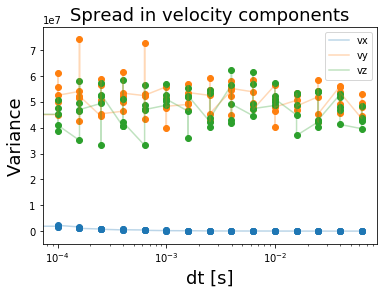

In [73]:
plt.plot(time_fix, vVar_fix[:, 0], alpha = 0.3)
plt.scatter(time_fix, vVar_fix[:, 0])
plt.plot(time_fix, vVar_fix[:, 1], alpha = 0.3)
plt.scatter(time_fix, vVar_fix[:, 1])
plt.plot(time_fix, vVar_fix[:, 2], alpha = 0.3)
plt.scatter(time_fix, vVar_fix[:, 2])
# plt.yscale('log')
plt.xscale('log')
plt.ylabel('Variance', fontsize = 18)
plt.xlabel('dt [s]', fontsize = 18)
plt.title('Spread in velocity components', fontsize = 18)
plt.legend(['vx', 'vy', 'vz'])
plt.savefig('velocity_spread.pdf')

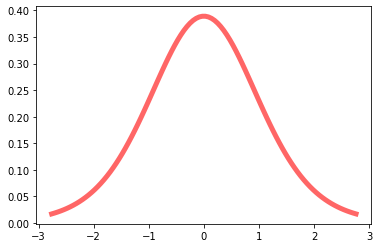

In [6]:
from scipy.stats import t
x = np.linspace(t.ppf(0.01, 10), t.ppf(0.99, 10), 100)
plt.plot(x, t.pdf(x, 10),'r-', lw=5, alpha=0.6, label='t pdf')

In [9]:
t.ppf(0.99, 9)

2.8214379233005493